In [41]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
from scipy.io import loadmat
%matplotlib inline

import os
import datetime
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/DailyLog/20180321/


In [2]:
datafile = '/home/brad/KA0002-day13-Combined-170827.mat'
with h5.File(datafile, 'r') as f:
    joyX = np.array(f['Down_Joy_X'])[0]
    joyY = np.array(f['Down_Joy_Y'])[0]
    dfof = np.array(f['dFoF_trace'])


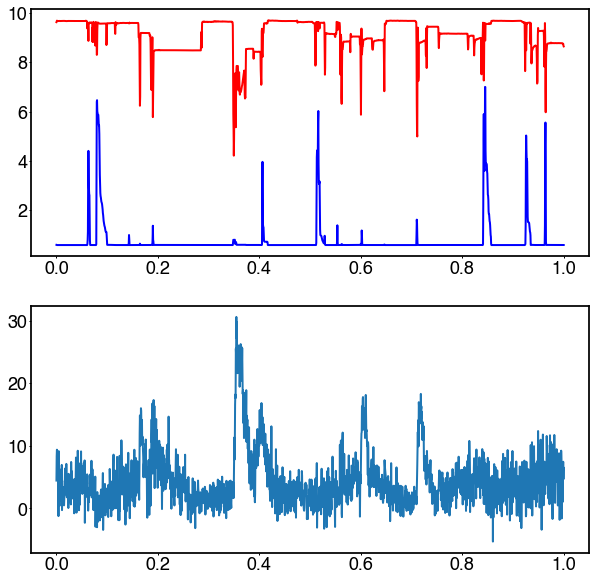

In [85]:
# plot data
unit = 5
t0 = 2500
l = 2000


plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
fig = plt.figure(figsize=(10, 10))
ax_X = fig.add_subplot(211)
ax_df = fig.add_subplot(212, sharex=ax_X)

t = np.linspace(0, 1, l)
# Plot X
xplot = ax_X.plot(t, joyX[t0:t0+l], 'r')
ax_X.plot(t, joyY[t0:t0+l], 'b')

# Plot df
ax_df.plot(t, dfof[unit, t0:t0+l])


In [17]:
import scipy.signal as sig

unit=22
# Lowpass filter
wn = 0.1
b, a = sig.butter(8, wn)
filtdf = sig.filtfilt(b, a, dfof, axis=1)

# Normalize dfof
maxes = np.amax(filtdf, axis=1)
maxmat = np.tile(maxes[:, np.newaxis], (1, filtdf.shape[1]))
filtdfn = np.divide(filtdf, maxmat)

#threshold
# thresh = 0.2
# filtdfn[filtdfn < thresh] = 0

# find threshold crossings
thresh = 0.2
dx = 1.0*np.logical_and((filtdfn[:,1:] > thresh), (filtdfn[:, 0:-1] < thresh))
print(dx.shape)
peaks = np.nonzero(dx)


# build binary matrix
binmat = np.zeros((dx.shape[0], dx.shape[1], 1))
for unit in range(dx.shape[0]):
    unittimes = peaks[1][peaks[0]==unit]
    binmat[unit, unittimes, 0] = 1.0
    
# # downsample
# ds_factor = 1 # number of adjacent time bins to merge
# binmat = binmat[:, 0:-ds_factor:ds_factor, :] + binmat[:, ds_factor::ds_factor, :]
# binmat.shape

# check largest simplex
maxD = np.amax(np.sum(binmat, axis=0))
print(maxD)

#compute bettis
import neuraltda.topology2 as tp2

bettis = tp2.do_compute_betti(binmat, np.arange(binmat.shape[0]), 'TK1', 4.0, False, 0, 1)

betti_dat = bettis['0']['0']['bettis']

(160, 31000)
7.0


NameError: name 'b3' is not defined

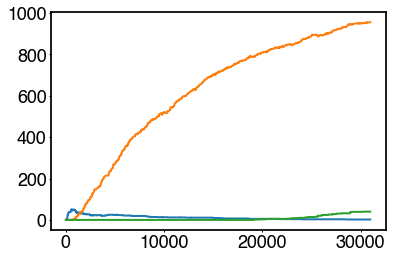

In [19]:
ts = [x[0] for x in betti_dat]
b0 = [x[1][0] for x in betti_dat]
b1 = [x[1][1] for x in betti_dat]
b2 = [x[1][2] for x in betti_dat]
#b3 = [x[1][3] for x in betti_dat]

plt.plot(ts, b0)
plt.plot(ts, b1)
plt.plot(ts, b2)
plt.plot(ts, b3)

In [ ]:
%env

In [ ]:
%env LD_LIBRARY_PATH=/home/brad/code/NeuralTDA/lib:$LD_LIBRARY_PATH

In [73]:
# pick random subsets of data and compute JS divergence vs. correlation of motion
length = 1000 # windows
nsamps = 100
ts = np.random.randint(0, high = binmat.shape[1] - length, size=nsamps)

# extract data
binmats = []
motions = []
shuffledbinmats = []
for t in ts:
    shuff = np.copy(binmat[:, t:t+length, :])
    binmats.append(binmat[:, t:t+length, :])
    motions.append(np.array([joyX[t:t+length], joyY[t:t+length]]))
    # generate permutations
    for unit in range(binmat.shape[0]):
         shuff[unit, :, 0] = np.random.permutation(shuff[unit, :, 0])
    shuffledbinmats.append(shuff)

In [68]:
binmats[0][1:20, 1:200, 0]


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

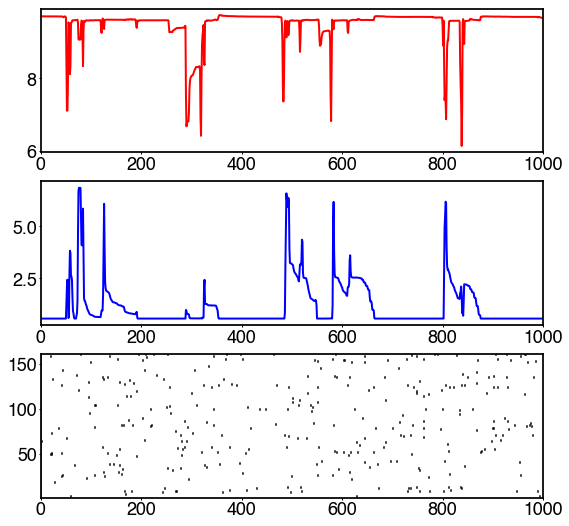

In [74]:
# plot some rasters
from ephys import rasters
plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')

for ind in range(0*len(binmats)+1):
    fig = plt.figure(figsize=(9,9))
    
    ax = fig.add_subplot(311)
    ax.plot(motions[ind][0], 'r')
    
    ax = fig.add_subplot(312, sharex=ax)
    ax.plot(motions[ind][1], 'b')
    
    ax = fig.add_subplot(313, sharex=ax)
    bm = shuffledbinmats[ind]
    rasterdat = [np.nonzero(bm[x, :])[0].astype(float) for x in range(bm.shape[0])]
    times = [0, length]
    #ticks = [0, length]
    rasters.do_raster(rasterdat, times, ticks, ax=ax)
    #plt.savefig(os.path.join(figsavepth, 'TK-X-Y-Transients{}.pdf'.format(ind)))

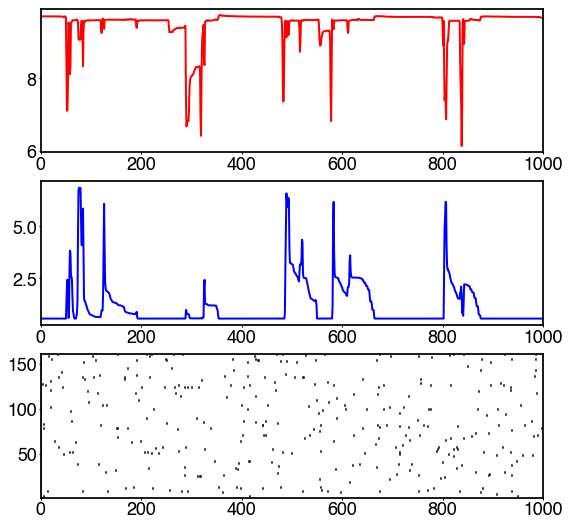

In [75]:
# plot some rasters
from ephys import rasters
plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')

for ind in range(0*len(binmats)+1):
    fig = plt.figure(figsize=(9,9))
    
    ax = fig.add_subplot(311)
    ax.plot(motions[ind][0], 'r')
    
    ax = fig.add_subplot(312, sharex=ax)
    ax.plot(motions[ind][1], 'b')
    
    ax = fig.add_subplot(313, sharex=ax)
    bm = binmats[ind]
    rasterdat = [np.nonzero(bm[x, :])[0].astype(float) for x in range(bm.shape[0])]
    times = [0, length]
    #ticks = [0, length]
    rasters.do_raster(rasterdat, times, ticks, ax=ax)
    #plt.savefig(os.path.join(figsavepth, 'TK-X-Y-Transients{}.pdf'.format(ind)))

In [76]:
   
# compute SCGs
import pycuslsa as pyslsa
import neuraltda.simpComp as sc
SCGs = []
shuffSCGs = []
for bm in binmats:
    
    maxsimps = sc.binarytomaxsimplex(bm[:, :, 0], rDup=False)
    SCGs.append(pyslsa.build_SCG(maxsimps))
    #print('Built SCG...')
    
for bms in shuffledbinmats:
    maxsimps = sc.binarytomaxsimplex(bms[:, :, 0], rDup=False)
    shuffSCGs.append(pyslsa.build_SCG(maxsimps))

In [77]:
import tqdm
dim = 1
beta = -1.0
crdat = []
for ind1 in tqdm.tqdm(np.arange(len(SCGs))):
    for ind2 in tqdm.tqdm(np.arange(ind1+1, len(SCGs))):
        SCG1 = SCGs[ind1]
        SCG2 = SCGs[ind2]
        sSCG1 = shuffSCGs[ind1]
        sSCG2 = shuffSCGs[ind2]
        mot1 = motions[ind1]
        mot2 = motions[ind2]
        
        mot1x = mot1[0]
        mot1y = mot1[1]
        mot2x = mot2[0]
        mot2y = mot2[1]
        
        mot1x = mot1x - np.mean(mot1x)
        mot1y = mot1y - np.mean(mot1y)
        mot2x = mot2x - np.mean(mot2x)
        mot2x = mot2y - np.mean(mot2y)
        
        
#         corx = np.corrcoef(mot1[0, :], mot2[0, :])
#         cory = np.corrcoef(mot1[1, :], mot2[1, :])
        corx = np.dot(mot1x, mot2x) / (np.linalg.norm(mot1x)*np.linalg.norm(mot2x))
        cory = np.dot(mot1y, mot2y) / (np.linalg.norm(mot1y)*np.linalg.norm(mot2y))
        js = pyslsa.cuJS(SCG1, SCG2, dim, beta)
        jsshuff = pyslsa.cuJS(sSCG1, sSCG2, dim, beta)
        crdat.append([js, corx, cory, jsshuff])

  9%|▉         | 9/96 [00:00<00:07, 10.97it/s]


 33%|███▎      | 31/93 [00:03<00:06,  9.98it/s]


 69%|██████▉   | 63/91 [00:07<00:03,  8.17it/s]


 67%|██████▋   | 59/88 [00:05<00:02, 10.98it/s]


 25%|██▌       | 21/84 [00:01<00:05, 11.81it/s]


 51%|█████     | 41/81 [00:04<00:04,  9.55it/s]


 94%|█████████▎| 73/78 [00:06<00:00, 11.72it/s]


 58%|█████▊    | 43/74 [00:03<00:02, 11.87it/s]


 87%|████████▋ | 62/71 [00:05<00:00, 11.82it/s]


 27%|██▋       | 18/66 [00:01<00:04, 10.73it/s]


  0%|          | 0/61 [00:00<?, ?it/s]


 14%|█▍        | 8/57 [00:00<00:04, 12.15it/s]


 65%|██████▌   | 34/52 [00:03<00:01, 10.47it/s]


 72%|███████▏  | 33/46 [00:03<00:01,  9.71it/s]


 32%|███▎      | 13/40 [00:01<00:02,  9.81it/s]


 66%|██████▌   | 66/100 [06:50<03:31,  6.22s/it][A


  8%|▊         | 2/25 [00:00<00:01, 11.92it/s]


 67%|██████▋   | 8/12 [00:00<00:00, 11.71it/s]


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]
0it [00:00, ?it/s]
100%|██████████| 100/100 [07:43<00:00,  4.63s/it]


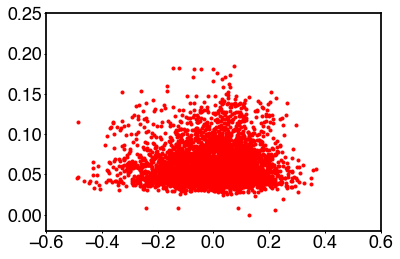

In [78]:
crdat = np.array(crdat)
plt.plot(crdat[:, 1], crdat[:, 0], 'r.')
plt.xlim([-0.6, 0.6])
plt.ylim([-0.02, 0.25])
plt.savefig(os.path.join(figsavepth, 'JSpairsvsXcor2.pdf'))

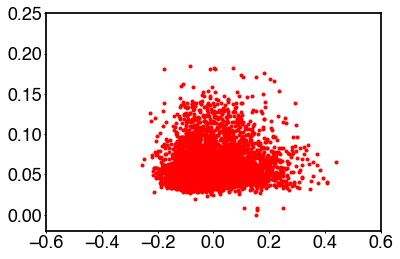

In [79]:
plt.plot(crdat[:, 2], crdat[:, 0], 'r.')
plt.xlim([-0.6, 0.6])
plt.ylim([-0.02, 0.25])
plt.savefig(os.path.join(figsavepth, 'JSpairsvsYcor2.pdf'))

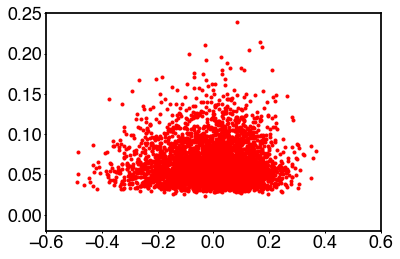

In [80]:
plt.plot(crdat[:, 1], crdat[:, 3], 'r.')
plt.xlim([-0.6, 0.6])
plt.ylim([-0.02, 0.25])
plt.savefig(os.path.join(figsavepth, 'JSpairsvsXcor2-shuff.pdf'))

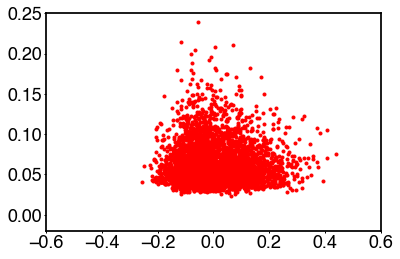

In [82]:
plt.plot(crdat[:, 2], crdat[:, 3], 'r.')
plt.xlim([-0.6, 0.6])
plt.ylim([-0.02, 0.25])
plt.savefig(os.path.join(figsavepth, 'JSpairsvsYcor2-shuff.pdf'))

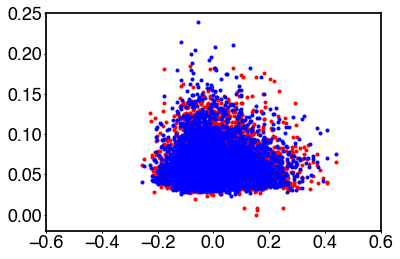

In [83]:
plt.plot(crdat[:, 2], crdat[:, 0], 'r.')
plt.plot(crdat[:, 2], crdat[:, 3], 'b.')
plt.xlim([-0.6, 0.6])
plt.ylim([-0.02, 0.25])
plt.savefig(os.path.join(figsavepth, 'JSpairsvsYcor2-shuff+orig.pdf'))

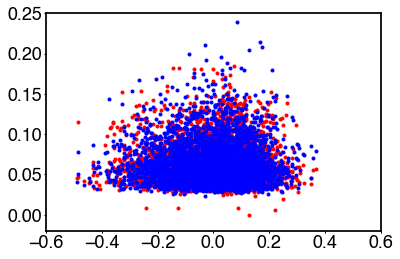

In [84]:
plt.plot(crdat[:, 1], crdat[:, 0], 'r.')
plt.plot(crdat[:, 1], crdat[:, 3], 'b.')
plt.xlim([-0.6, 0.6])
plt.ylim([-0.02, 0.25])
plt.savefig(os.path.join(figsavepth, 'JSpairsvsXcor2-shuff+orig.pdf'))

In [55]:
# Bin the X-axis and slice up the data into these bins to compute JS spread as a function of correlation

bins = np.linspace(-0.6, 0.6, 20)
# Y correlation first
ycorsortinds = np.argsort(crdat[:, 2])
sortedYJS = crdat[ycorsortins, 0]
sortedYcorr = crdat[ycorsortins, 2]

ybininds = np.digitize(sortedYcorr, bins)
for 


array([ 9, 11,  9, ..., 10, 13, 10])

In [ ]:

plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
fig = plt.figure(figsize=(10, 10))
ax_X = fig.add_subplot(211)
ax_df = fig.add_subplot(212, sharex=ax_X)

t = np.linspace(0, 1, l)
# Plot X
xplot = ax_X.plot(t, joyX[t0:t0+l], 'r')
ax_X.plot(t, joyY[t0:t0+l], 'b')

# Plot df
#thresh = 0.15
#goodpeaks = peaks[filtdfn[unit, peaks] > thresh]
goodpeaks = peaks
ax_df.plot(t, filtdfn[unit, t0:t0+l])
ax_df.plot(goodpeaks/l, len(goodpeaks)*[0.5], 'r.')
#ax_df.plot(t, dx[unit, t0:t0+l])

In [56]:
crdat.shape

(4950, 3)

In [ ]:
filtdfn[unit, peaks] 